<a href="https://colab.research.google.com/github/FranciscaAlliende/APS-Failure-at-Scania-Trucks/blob/master/ScaniaTrucks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


STEPS:
1. basic_prepro
 - input: raw dataset
 - output: basic preprocessesed dataset
2. null_values
 - input: basic preprocessesed train + test sets
 - output: y_train, X_train, y_test, X_test, wihout null values
 * hyperparameter. t: % of null values for a feature to be consideR: set at 50%
3. unbalanced classes (downsampling or SMOTE)
 - input: y, X unbalance pair
 - output: y, X balanced pair
 * hyperparameter: SMOTE number of neighbors: set at 100
4. dimensionality reduction(Random Forest or PCA)
 - input: X_train, y_train after unbalanced class and X_test after null_values
 - output: X_train and X_test with the selected features
 * hyperparameters:
    - Random Forest: n_estimators: set at 100 and g: feature importance (gini) threshold, set after vizualizing the corresponding graph at 0.02 for downsampling and 0.015 for upsampling.  
    - PCA: nc: number of components, set at 80



In [2]:
import pandas as pd
import basic_prepro as bp
import null_values as nv
import unbalanced_classes as uc
import dim_reduction as dr

In [3]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_training_set.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_test_set.csv')

In [4]:
# basic prepocessing
train = bp.data_prepro(train)
test = bp.data_prepro(test)

In [5]:
# null values
[y_train, X_train, y_test, X_test] = nv.null_values(train, test, t=0.5)

In [6]:
# downsampling
[y_down_train, X_down_train] = uc.downsampling(y_train, X_train)

In [7]:
# upsampling
[y_up_train, X_up_train] = uc.mySMOTE(y_train, X_train, 100)

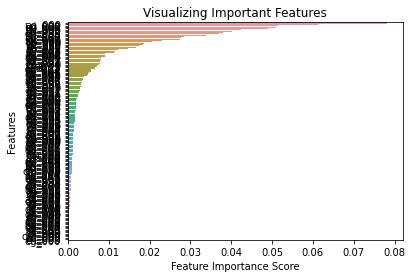

N selected features: 15


In [8]:
# dimensionality reduction RF + downsampling
[X_train_down_RF, X_test_down_RF] = dr.RF(X_down_train, y_down_train, X_test, n_estimators=100, g=0.02)

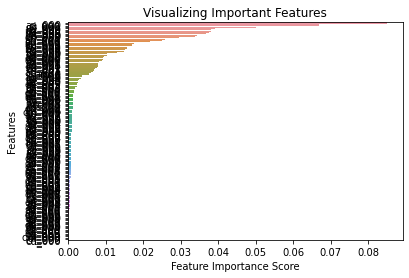

N selected features: 21


In [9]:
# dimensionality reduction RF + upsampling
[X_train_up_RF, X_test_up_RF] = dr.RF(X_up_train, y_up_train, X_test, n_estimators=100, g=0.015)

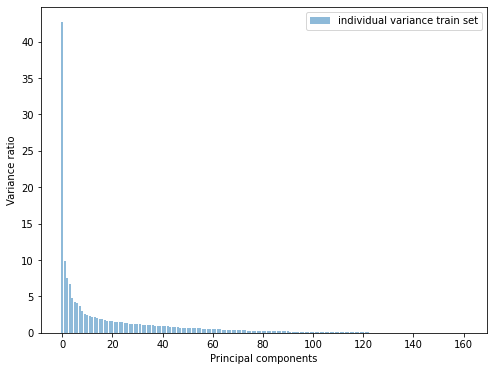

In [10]:
# dimensionality reduction PCA + downsampling
[X_train_down_PCA, X_test_down_PCA] = dr.myPCA(X_down_train, X_test, 80)

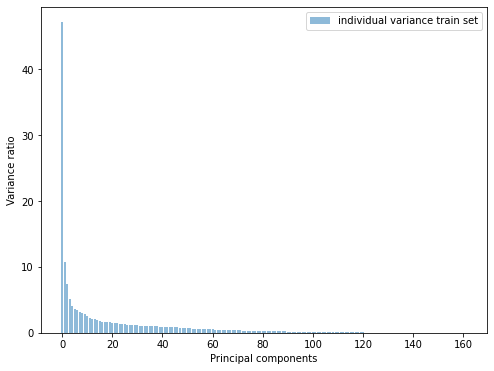

In [11]:
# dimensionality reduction PCA + upsampling
[X_train_up_PCA, X_test_up_PCA] = dr.myPCA(X_up_train, X_test, 80)